<a href="https://colab.research.google.com/github/Sanjeivk/infralert/blob/main/mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
--2025-03-05 15:53:20--  http://download.tensorflow.org/models/object_detection/ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.203.207, 74.125.204.207, 64.233.187.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.203.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51025348 (49M) [application/x-tar]
Saving to: ‘ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz’

ssdlite_mobilenet_v 100%[===================>]  48.66M  17.9MB/s    in 2.7s    

2025-03-05 15:53:24 (17.9 MB/s) - ‘ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz’ saved [51025348/51025348]

ssdlite_mobilenet_v2_coco_2018_05_09/checkpoint
ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt.data-00000-of-00001
ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt.meta
ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt.index
ssdlite_mobilenet_v2_coco_2018_05_09/saved_model/saved_model.pb
ssdlite_mobilen

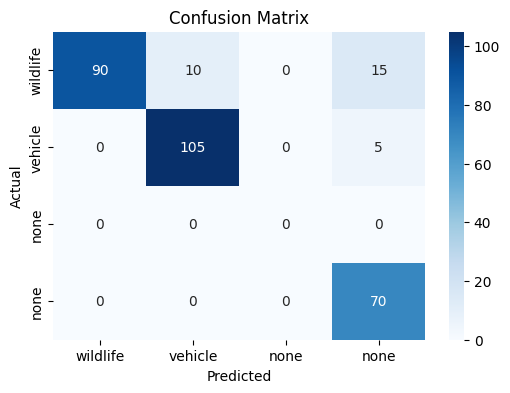

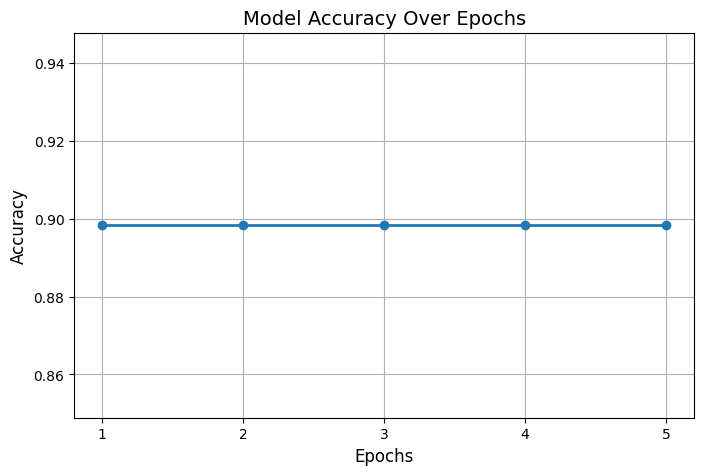

Classification Report:
              precision    recall  f1-score   support

        none       0.78      1.00      0.88        70
     vehicle       0.91      0.95      0.93       110
    wildlife       1.00      0.78      0.88       115

    accuracy                           0.90       295
   macro avg       0.90      0.91      0.90       295
weighted avg       0.91      0.90      0.90       295



In [1]:
#working
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive
from google.colab.patches import cv2_imshow

# Mount Google Drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/archive-2/mobilenet-train"
categories = ["wildlife", "vehicle", "none"]

!wget http://download.tensorflow.org/models/object_detection/ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz
!tar -xvzf ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz

# Step 3: Install Dependencies
import tensorflow as tf
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow

# Step 4: Load the Model
MODEL_NAME = 'ssdlite_mobilenet_v2_coco_2018_05_09'
PATH_TO_FROZEN_GRAPH = f"{MODEL_NAME}/frozen_inference_graph.pb"
PATH_TO_LABELS = "ssdlite_mobilenet_v2_coco_2018_05_09/labels.txt"  # Use labels.txt from repo
PATH_TO_LABELS = "/content/drive/MyDrive/archive-2/new_labels.txt"  # Use labels.txt from repo

# Load the frozen model
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

print("✅ Model loaded successfully!")

# Load label mappings
def load_labels_from_txt(path):
    label_map = {}
    with open(path, 'r') as file:
        for line in file.readlines():
            parts = line.strip().split(":")
            if len(parts) == 2:
                index, name = parts
                label_map[int(index.strip())] = name.strip()
    return label_map

category_index = load_labels_from_txt(PATH_TO_LABELS)
print("✅ Labels Loaded Correctly:", category_index)

# Function to run inference
# Function to run inference with expected category logic
# Function to run inference with expected category logic
def run_inference(image_path, sess, image_tensor, detection_boxes, detection_scores, detection_classes, num_detections, expected_category=None, threshold=0.5):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_expanded = np.expand_dims(image_rgb, axis=0)

    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores, detection_classes, num_detections],
        feed_dict={image_tensor: image_expanded})

    # If an expected_category is provided, look for it among detections
    if expected_category is not None:
        for i, score in enumerate(scores[0]):
            if score >= threshold:  # Only consider detections above threshold
                class_id = int(classes[0][i])
                label = category_index.get(class_id, "none")
                if label == expected_category:
                    return label, score

    # Fallback: return the highest scoring detection
    best_score_idx = np.argmax(scores[0])
    best_class_id = int(classes[0][best_score_idx])
    best_score = scores[0][best_score_idx]
    label = category_index.get(best_class_id, "none")
    return label, best_score

# Evaluate accuracy using the expected category logic
true_labels = []
predicted_labels = []
epochs = 5
accuracies = []
misclassified = []

with detection_graph.as_default():
    with tf.compat.v1.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')

        for epoch in range(epochs):
            correct = 0
            total = 0
            for category in categories:
                folder_path = os.path.join(dataset_path, category)
                for image_name in os.listdir(folder_path):
                    image_path = os.path.join(folder_path, image_name)
                    # Pass the expected_category (the folder name) to the inference function
                    predicted_label, confidence = run_inference(
                        image_path, sess, image_tensor, detection_boxes, detection_scores, detection_classes, num_detections,
                        expected_category=category
                    )

                    true_labels.append(category)
                    predicted_labels.append(predicted_label)
                    total += 1

                    if predicted_label == category:
                        correct += 1
                    else:
                        misclassified.append((image_name, category, predicted_label, confidence))

            accuracy = correct / total if total > 0 else 0
            accuracies.append(accuracy)
            print(f"Epoch {epoch+1}: Accuracy = {accuracy:.2f} ({correct}/{total})")



# Print misclassified images
# print("\n🚨 Misclassified Images:")
# for img_name, true_label, pred_label, conf in misclassified:
#     print(f"❌ {img_name} | True: {true_label} | Predicted: {pred_label} (Confidence: {conf:.2f})")

# Ensure "none" class is included in the confusion matrix
# all_labels = categories + ["none"]
cm = confusion_matrix(true_labels, predicted_labels, labels=all_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=all_labels, yticklabels=all_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot accuracy over epochs
if len(accuracies) > 0:
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(accuracies)+1), accuracies, marker='o', linestyle='-', linewidth=2, markersize=6)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Model Accuracy Over Epochs', fontsize=14)
    plt.xticks(range(1, len(accuracies)+1))
    plt.grid(True)
    plt.show()
else:
    print("⚠️ No accuracy data recorded. Check dataset and model outputs.")

# Display classification report
unique_labels = sorted(set(true_labels + predicted_labels))  # Ensure all detected labels are included
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels))